## kaggle泰坦尼克号机器学习stacking模型融合

In [236]:
import numpy as np
import pandas as pd
import re 
import sklearn
import os
# 显示当前路径
os.getcwd()

'D:\\jupyter_notebook'

In [237]:
# 导入数据
train_ = pd.read_csv('D:/jupyter_notebook/titanic/train.csv')
test_ = pd.read_csv('D:/jupyter_notebook/titanic/test.csv')

In [238]:
# 为方便进行数据处理，将训练集和测试集合并进行数据处理
train_['number'] = 1 
test_['number'] = 0
datamart = pd.concat([train_, test_], axis=0, join='outer')  

C:\Users\IBM\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




### 1.根据原始特征进行特征处理，训练集和测试集合并处理

In [239]:
#根据原始特征的观察构建新特征
# 计算名字的长度
datamart['Name_length'] = datamart['Name'].apply(len)
# 将旅客是否住在头等舱二值化
datamart['Has_Cabin'] = datamart["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
# 构建新特征家庭总人数
datamart['FamilySize'] = datamart['SibSp'] + datamart['Parch'] + 1
# 构建新特征是否独居
datamart['IsAlone'] = 0
datamart.loc[datamart['FamilySize'] == 1, 'IsAlone'] = 1
# 查看乘客登船口岸存在缺失值
datamart['Embarked'].isnull().value_counts() 
# 对乘客登船口岸进行固定值填充缺失值
datamart['Embarked'] = datamart['Embarked'].fillna('S')
# 对票价进行中位数填充缺失值
datamart['Fare'] = datamart['Fare'].fillna(datamart['Fare'].median())
# 生成绝对票价分区，qcut是根据分区分位定义，将每一个值划为到具体的分区区间中去，此处定义为四分位值
datamart['CategoricalFare'] = pd.qcut(datamart['Fare'], 4)
# 生成新变量年龄平均值、年龄标准差
age_avg = datamart['Age'].mean()
age_std = datamart['Age'].std()
# 计算年龄是否有缺失值并统计
age_null_count = datamart['Age'].isnull().sum()
# np.random.randint()产生离散均匀分布的整数,size是产生的元素数量，前面分别为最小值和最大值区间
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
# 对年龄用生成的一些新数值进行填充
datamart['Age'][np.isnan(datamart['Age'])] = age_null_random_list
# 转换变量类型为数值类型，便于后期计算
datamart['Age'] = datamart['Age'].astype(int)
# 对年龄生成新的分箱变量中来代替，即将年龄绝对值转换为离散类别
datamart['CategoricalAge'] = pd.cut(datamart['Age'], 5)

# 定义正则表达式函数导出旅客的Title
def get_title(name):
    # re.search()方法扫描整个字符串，并返回第一个成功的匹配。如果匹配失败，则返回None
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ''

# 取出姓名中尊称部分
datamart['Title'] = datamart['Name'].apply(get_title)

# 对姓名的称呼部分做统一
datamart['Title'] = datamart['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major'
                                           , 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
datamart['Title'] = datamart['Title'].replace('Mlle', 'Miss')
datamart['Title'] = datamart['Title'].replace('Ms', 'Miss')
datamart['Title'] = datamart['Title'].replace('Mme', 'Mrs')

# 对性别从离散型替换为数值型
datamart['Sex'] = datamart['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
# 对姓名的称呼部分做数值型变换
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# 先定义一个字典，然后通过map函数传入字典进行替换
datamart['Title'] = datamart['Title'].map(title_mapping)
# 最后对缺失值替换为0
datamart['Title'] = datamart['Title'].fillna(0)
    
# 替换登船口岸
datamart['Embarked'] = datamart['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
# 替换票价的四分位数，该步骤应该有更好的办法做数据处理
# loc函数取出列中某类元素的数据集
datamart.loc[ datamart['Fare'] <= 7.91, 'Fare'] = 0
datamart.loc[(datamart['Fare'] > 7.91) & (datamart['Fare'] <= 14.454), 'Fare'] = 1
datamart.loc[(datamart['Fare'] > 14.454) & (datamart['Fare'] <= 31), 'Fare']   = 2
datamart.loc[ datamart['Fare'] > 31, 'Fare'] = 3
datamart['Fare'] = datamart['Fare'].astype(int)
    
# 对年龄进行分段
datamart.loc[ datamart['Age'] <= 16, 'Age'] = 0
datamart.loc[(datamart['Age'] > 16) & (datamart['Age'] <= 32), 'Age'] = 1
datamart.loc[(datamart['Age'] > 32) & (datamart['Age'] <= 48), 'Age'] = 2
datamart.loc[(datamart['Age'] > 48) & (datamart['Age'] <= 64), 'Age'] = 3
datamart.loc[datamart['Age'] > 64, 'Age'] = 4


# 特征选择，先对处理过的不需要的特征进行删除，定义一个列表，然后批量删除
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
datamart = datamart.drop(drop_elements, axis = 1)
datamart = datamart.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
# test_  = test_.drop(drop_elements, axis = 1)

datamart.head()

C:\Users\IBM\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Age,Embarked,Fare,Parch,Pclass,Sex,Survived,number,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,0,0,3,1,0.0,1,23,0,2,0,1
1,2,1,3,0,1,0,1.0,1,51,1,2,0,3
2,1,0,1,0,3,0,1.0,1,22,0,1,1,2
3,2,0,3,0,1,0,1.0,1,44,1,2,0,3
4,2,0,1,0,3,1,0.0,1,24,0,1,1,1


### 2.对特征处理后的测试集和训练集分开

In [240]:
# 通过loc方法选取训练集的数据
train_new = datamart.loc[datamart['number'] == 1]
# 对number列进行删除
train_new = train_new.drop(['number'],axis=1)

In [241]:
train_new.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,Survived,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,0,0,3,1,0.0,23,0,2,0,1
1,2,1,3,0,1,0,1.0,51,1,2,0,3
2,1,0,1,0,3,0,1.0,22,0,1,1,2
3,2,0,3,0,1,0,1.0,44,1,2,0,3
4,2,0,1,0,3,1,0.0,24,0,1,1,1


In [242]:
test_new = datamart.loc[datamart['number'] == 0]
drop_columns = ['number','Survived']
test_new = test_new.drop(drop_columns,axis=1)

In [243]:
test_new.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,2,2,0,0,3,1,16,0,1,1,1
1,2,0,0,0,3,0,32,0,2,0,3
2,3,2,1,0,2,1,25,0,1,1,1
3,1,0,1,0,3,1,16,0,1,1,1
4,1,0,1,1,3,0,44,0,3,0,3


### 3.导入机器学习库对数据特征进行探索

In [244]:
import sklearn
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

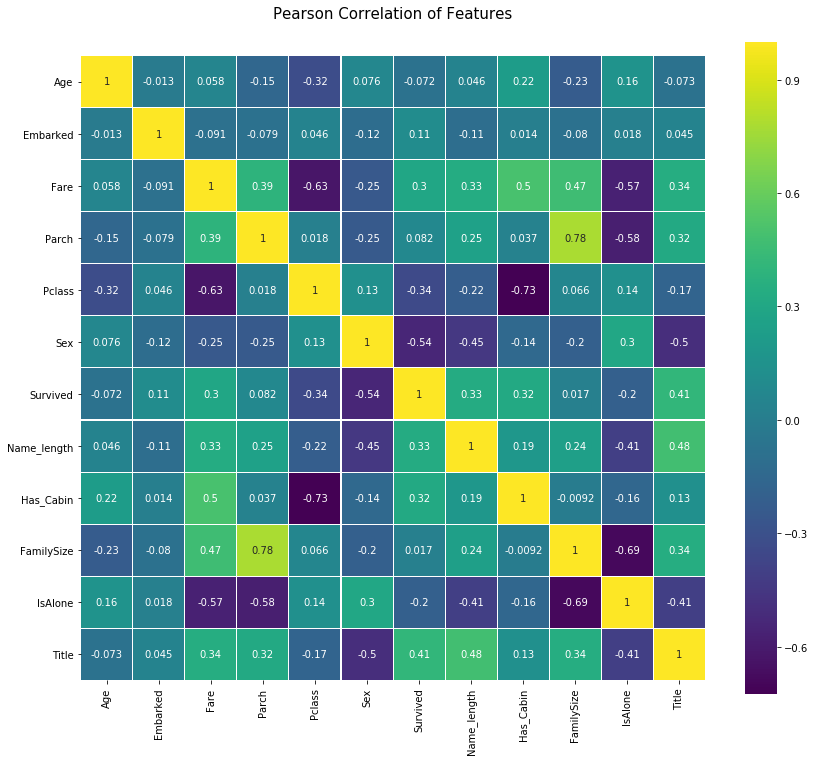

In [245]:
# 现在可视化
# Pearson相关系数查看所有特征之间的关联性，一方面排除特征高度相关的特征，一方面查看特征之间的关系
# 可视化特征之间的关联
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# 定义画布的背景色
# colormap = plt.cm.RdBu
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_new.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Pearson Correlation图可以告诉我们的一件事是，没有太多的特征彼此强烈相关。从将这些特征提供到学习模型中的观点来看，这是很好的，因为这意味着我们的训练集中没有太多冗余或多余的数据，我们很高兴每个特征都带有一些独特的信息。这里有两个最相关的特征是家庭大小和Parch（父母和孩子）。为了本练习的目的，我仍然会将这两个功能都保留下来。Pairplots最后让我们生成一些配对图来观察从一个特征到另一个特征的数据分布。我们再次使用Seaborn来帮助我们。

C:\Users\IBM\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.

C:\Users\IBM\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\IBM\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



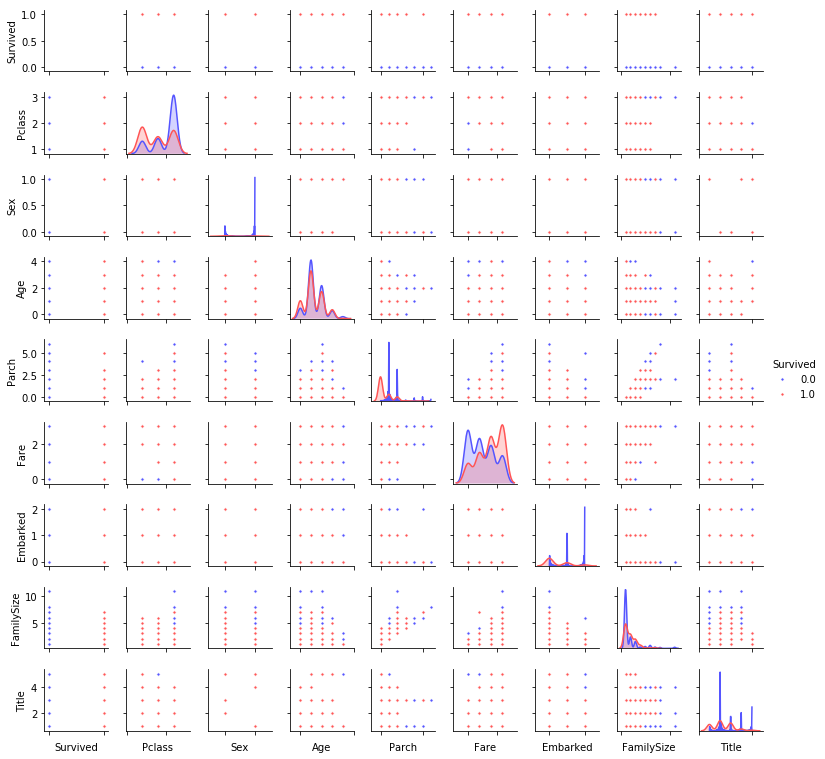

In [246]:
g = sns.pairplot(train_new[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [247]:
# 查看前期写代码做的字典对应，方便理解特征的含义
# train_data.rename(columns={'PassengerId':'旅客ID','Survived':'是否生存标签','Pclass':'票仓等级','Name':'姓名'
#                    , 'Sex':'性别', 'Age':'年龄', 'SibSp':'兄弟姐妹及配偶个数', 'Parch':'父母或子女个数'
#                    , 'Ticket':'船票号', 'Fare':'票价', 'Cabin':'所在仓位', 'Embarked':'乘客登船口岸'
#                   }, inplace = True)

### 4.Stacking集成学习开始

In [248]:
# 一些有用的参数将在以后派上用场
# 在这里，我们调用Python的类来帮助我们更方便。对于任何新的编程人员，通常会听到与面向对象编程（OOP）结合使用的类。
# 简而言之，类有助于扩展一些代码/程序来创建对象（旧学校窥视的变量）以及实现特定于该类的函数和方法。
# 在下面的代码部分中，我们基本上编写了一个SklearnHelper类，它允许扩展所有Sklearn分类器共有的内置方法（如train，predict和fit）。
# 因此，如果我们想要调用五个不同的分类器，这将消除冗余，因为不需要编写相同的方法五次。

In [249]:
ntrain = train_new.shape[0] # 统计样本的训练集的矩阵行数 shape[1]是统计矩阵的列数
ntest = test_new.shape[0]
SEED = 0 # 用于迭代，先初始化
NFOLDS = 5 # 定义K折交叉验证的折数，这里定义是5折交叉验证
kf = KFold(n_splits=NFOLDS,random_state=SEED)

In [250]:
# 用类来延伸定义分类器，通过面向对象编程的方式定义学习器

In [251]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [252]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for train_index, test_index in kf.split(train_new):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [253]:
# 对于那些已经知道这一点的人，请耐心等待，但对于之前没有在Python中创建过类或对象的人，请让我解释一下上面给出的代码。
# 在创建我的基本分类器时，我将仅使用Sklearn库中已存在的模型，因此仅扩展该类。** def init **：用于调用类的默认构造函数的Python标准。
# 这意味着当你想要创建一个对象（分类器）时，你必须给它clf（你想要的sklearn分类器），种子（随机种子）和params（分类器的参数）的参数。
# 其余代码只是类的方法，它只调用sklearn分类器中已存在的相应方法。
# 本质上，我们已经创建了一个包装类来扩展各种Sklearn分类器，这样我们就可以帮助我们减少在我们向堆栈器实现多个学习器时反复编写相同的代码。

In [254]:
# 现在如上文在介绍部分中所提到的，堆叠使用基础分类器的预测作为对第二级模型的训练的输入。
# 然而，不能简单地在完整训练数据上训练基础模型，在完整测试集上生成预测，然后将这些预测输出到第二级训练。
# 这会冒你的基础模型预测已经“看到”测试集并因此在提供这些预测时过度拟合的风险。

### 生成一级基础模型

#### 所以现在让我们准备五个学习模型作为我们的第一级分类。这些模型都可以通过Sklearn库方便地调用。
如下所示：
1. 随机森林分类器
2. 额外的树木分类器
3. AdaBoost分类
4. Gradient Boosting classifer
5. 支持向量机

In [255]:
# 参数描述如下
# 只是我们将在此列出的完整性参数的快速摘要，n_jobs：用于培训过程的核心数。如果设置为-1，则使用所有核心。
# n_estimators：学习模型中的分类树数量（默认设置为10）max_depth：树的最大深度，或节点应扩展的程度。
# 请注意，如果设置得太高，则数字会冒着过度拟合的风险，因为人们会过长地生长树verbose：控制是否要在学习过程中输出任何文本。
# 值0将抑制所有文本，而值3则在每次迭代时输出树学习过程。请通过Sklearn官方网站查看完整说明。在那里你会发现你可以使用其他许多有用的参数。

In [256]:
# 定义以下分类器的各类参数
# Random Forest parameters随机森林
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters极限森林
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters 
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters渐变提升树
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 支持向量机参数
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

#### 此外，由于已经提到了面向对象框架中的对象和类，现在让我们通过我们之前定义的Helper Sklearn类创建5个对象，这些对象代表我们的5个学习模型。

In [257]:
# 建立5个对象来代表五个模型
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

从我们的训练集和测试集中创建NumPy数组。在准备好我们的第一层基础模型之后，我们现在可以通过从原始数据生成NumPy数组来准备训练和测试测试数据以输入到我们的分类器中，如下所示：

In [258]:
# 建立训练集和测试集、目标变量数组，用于模型的输入
y_train = train_new['Survived'].ravel()
train = train_new.drop(['Survived'], axis=1)
x_train = train.values # 将pandas转换为数组
x_test = test_new.values # 将pandas转换为数组

#### 生成第一级的模型预测的输出
我们现在将训练和测试数据提供给我们的5个基本分类器，并使用我们之前定义的Out-of-Fold预测函数来生成我们的第一级预测。允许少数几分钟运行下面的代码块。

In [259]:
# 建立面向对象的训练和测试预测，然后这些结果将被作为新的特征使用
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

C:\Users\IBM\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

C:\Users\IBM\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

C:\Users\IBM\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

C:\Users\IBM\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



Training is complete


从不同分类器生成的要素重要性现在我们已经学习了第一级分类器，我们可以利用Sklearn模型的一个非常漂亮的功能，即通过一行非常简单的代码输出训练和测试集中各种功能的重要性。根据Sklearn文档，大多数分类器都内置了一个属性，只需键入.feature_importances_即可返回要素重要性。因此，我们将通过我们的函数earliand调用这个非常有用的属性来绘制特征重要性

In [260]:
# 由于svc支持向量机没有特征重要性这个类可以调用，因此本次仅仅定义四个模型的特征重要性
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.03395156 0.02204867 0.07580762 0.02130413 0.12930858 0.20991564
 0.10495075 0.0601377  0.06653321 0.01245685 0.26358529]


C:\Users\IBM\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:308: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[0.03210895 0.02780961 0.05542151 0.01591271 0.12262062 0.3823525
 0.04763106 0.08549833 0.04361753 0.02021635 0.16681083]
[0.016 0.008 0.04  0.068 0.034 0.012 0.686 0.014 0.052 0.004 0.066]
[0.0553183  0.02327941 0.05337294 0.01091944 0.08269741 0.01127834
 0.17445245 0.03755093 0.11227416 0.00770645 0.43115018]


所以我还没有弄清楚如何直接分配和存储功能重要性。因此，我将打印出上面代码中的值，然后简单地复制并粘贴到Python列表中，如下所示

## # 此次复制的结果和我自己改代码后的运行的特征重要性结果完全不同，需要核对为什么

In [262]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

从包含要素重要性数据的列表创建数据框，以便通过Plotly包进行简单的绘图。

In [264]:
cols = train.columns.values
# 对特征重要性创建一个DataFrame以便后期作图
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

通过Plotly散点图进行交互式要素导入我将在此时使用交互式Plotly包，通过调用“Scatter”，通过绘图散点图可视化不同分类器的要素重要性值，如下所示：

In [265]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### 现在让我们计算所有要素重要性的平均值，并将其存储为要素重要性数据框中的新列。

In [266]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Age,0.104741,0.121657,0.028,0.067961,0.080590
1,Embarked,0.218370,0.370983,0.008,0.038893,0.159062
2,Fare,0.044327,0.031296,0.012,0.072378,0.040000


### 平均特征重要性的Plotly Barplot获得所有分类器的平均特征重要性后，我们可以将它们绘制成Plotly条形图，如下所示：

In [267]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## 用第一级输出作为二级的特征构建并进行预测

作为新功能的第一级输出现在已经获得了我们的第一级预测，人们可以将其视为基本上构建一组新功能，用作下一个分类器的训练数据。根据下面的代码，我们将新列作为我们之前的分类器中的第一级预测，并在此基础上训练下一个分类器。

In [269]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### 二级训练集的相关热图

In [270]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

已经有不少文章和Kaggle比赛获奖者关于训练模型的优点，这些模型彼此之间更不相关，产生更好的分数。

In [272]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

现在已经连接并加入了第一级列车和测试预测x_train和x_test，我们现在可以适应二级学习模型。

## 通过XGBoost的二级学习模型在这里，我们选择了极其着名的分类器，用于提升树学习模型，XGBoost。
它的构建是为了优化大规模的提升树算法。有关该算法的更多信息，请查看官方文档。无论如何，我们称之为XGBC分类器并将其与第一级训练和目标数据相匹配，并使用学习模型预测测试数据，如下所示：

In [274]:
import xgboost as xgb 
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

只需快速了解模型中使用的XGBoost参数：max_depth：你想要树的深度。请注意，如果设置得太高，则数字可能存在过度拟合的风险。gamma：在树的叶节点上进行进一步分区所需的最小损耗减少。算法越大，越保守。eta：每个增压步骤中使用的步长收缩，以防止过度拟合

In [279]:
# 生成预测文件并保存
PassengerId = test_['PassengerId']
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

进一步改进的步骤作为结束语，必须注意的是，上面采取的步骤只是展示了一种生成整体堆垛机的非常简单的方法。你会听到在最高级别的Kaggle比赛中创造的合奏，其中涉及堆叠分类器的怪异组合以及达到2级以上的堆叠等级。可以采取一些额外步骤来提高一个人的分数：在训练模型时实施良好的交叉验证策略以找到最佳参数值引入更多种类的基础模型进行学习。结果越不相关，最终得分越高。

结论我有这个笔记本在介绍堆叠学习模型的工作脚本方面有所帮助。再次信用必须扩展到法隆和新浪。有关一般堆叠或整理的其他优秀材料，请参阅MLWave：Kaggle Ensembling Guide网站上的事实必读文章。直到下一次，再见